# Computer Vision Course Project

## Park Vision


### Setup

In [3]:
%pip install --quiet ultralytics scikit-learn opencv-python tqdm matplotlib pandas kagglehub

Note: you may need to restart the kernel to use updated packages.


In [1]:
import kagglehub
import torch

from ultralytics import YOLO #Handles YOLO class from YOLOV8 Library
from ultralytics.utils.plotting import Annotator #Annotator for bounding boxes and image labels

import cv2 #OpenCV

import os #Operating system (directories/files)
import shutil #High level file operations (ex. copy/delete directories)
import random #Used for randomly splitting or augmenting dataset
import xml.etree.ElementTree as ET #Parse/Manipulate XML files
from sklearn.model_selection import train_test_split #Used to split dataset into training validation and test sets
from tqdm import tqdm #Used to add progress bar to loops

import matplotlib.pyplot as plt #Image, chart plotter
import pandas as pd #Data analysis library

import json
import yaml

d:\AAA DESKTOP 2.0\Coding\Python\School\ParkVision\ParkVision\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# command to install cuda (for 3080)
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

Looking in indexes: https://download.pytorch.org/whl/cu126
  Using cached https://download.pytorch.org/whl/cu126/torchaudio-2.6.0%2Bcu126-cp311-cp311-win_amd64.whl.metadata (6.8 kB)
  Using cached https://download.pytorch.org/whl/cu126/torch-2.6.0%2Bcu126-cp311-cp311-win_amd64.whl.metadata (28 kB)
Using cached https://download.pytorch.org/whl/cu126/torchaudio-2.6.0%2Bcu126-cp311-cp311-win_amd64.whl (4.2 MB)
Using cached https://download.pytorch.org/whl/cu126/torch-2.6.0%2Bcu126-cp311-cp311-win_amd64.whl (2496.1 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.6.0
    Uninstalling torch-2.6.0:
      Successfully uninstalled torch-2.6.0
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.


In [2]:
# Check if MPS is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"device: {device}")

device: cuda


In [ ]:
# # Download latest version
# path = kagglehub.dataset_download("blanderbuss/parking-lot-dataset")

# print("Path to dataset files:", path)

In [18]:
# Download latest version
carpk_coco_path = kagglehub.dataset_download("kambojharyana/carpk-coco", force_download=True)
pld_path = kagglehub.dataset_download("muhwira/parking-lot-dataset")

print("Path to dataset files:", carpk_coco_path)
print("Path to dataset files:", pld_path)

100%|██████████| 1.94G/1.94G [00:41<00:00, 50.2MB/s]

Extracting files...


Path to dataset files: C:\Users\jacob\.cache\kagglehub\datasets\kambojharyana\carpk-coco\versions\1
Path to dataset files: C:\Users\jacob\.cache\kagglehub\datasets\muhwira\parking-lot-dataset\versions\1


### Test YOLO and annotations are functioning correctly

YOLOv8n summary: 129 layers, 3,157,200 parameters, 0 gradients, 8.9 GFLOPs

image 1/1 d:\AAA DESKTOP 2.0\Coding\Python\School\ParkVision\ParkVision\06-object-detection-using-yolo\bus.jpg: 640x480 4 persons, 1 bus, 1 stop sign, 400.6ms
Speed: 58.3ms preprocess, 400.6ms inference, 104.3ms postprocess per image at shape (1, 3, 640, 480)


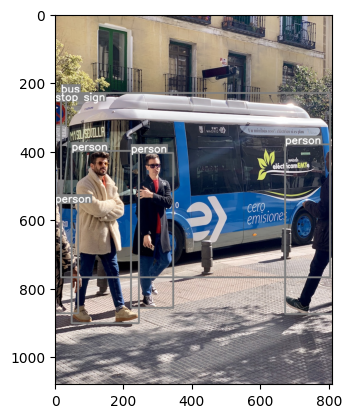

In [4]:
model = YOLO('06-object-detection-using-yolo/yolov8n.pt')
model.info()
results = model('06-object-detection-using-yolo/bus.jpg')


annotator = Annotator(cv2.cvtColor(results[0].orig_img, cv2.COLOR_BGR2RGB))
boxes = results[0].boxes
for box in boxes:
    b = box.xyxy[0]  # get box coordinates in (left, top, right, bottom) format
    c = box.cls
    annotator.box_label(b, model.names[int(c)])

plt.imshow(annotator.result())

### Transform PKLot the dataset to be YOLO ready

In [ ]:
# #----------------------------------------
# # Define class map
# #----------------------------------------

# class_name_to_id_mapping = {
#     "vacant": 0,
#     "occupied": 1
# }

# #----------------------------------------
# # Determine Paths
# #----------------------------------------

# #Original Dataset Location
# root_dir = "PKLot"

# #New Yolo Ready Dataset
# outputDir = "PKLot_YOLORdy"
# imagesOutput = os.path.join(outputDir, "images")
# labelsOutput = os.path.join(outputDir, "labels")

# for sub in ['train', 'val', 'test']:
#     os.makedirs(os.path.join(imagesOutput, sub), exist_ok=True) #Path to store images
#     os.makedirs(os.path.join(labelsOutput, sub), exist_ok=True) #Path to store YOLO labels


# #----------------------------------------
# # Parse XML annoatation files
# #----------------------------------------

# def extract_info_from_xml(xml_path): #Function to extract bounding boxes from XML files
#     tree = ET.parse(xml_path)
#     root = tree.getroot()

#     filename = os.path.splitext(os.path.root_dirname(xml_path))[0] + ".jpg" #Get corresponding image filename
#     bboxes = [] #List of bounding boxes for this image

#     for space in root.findall("space"): #Loop through each sapce tag in XML (which is a spot)

#         #Get the occupancy state from XML annoatation
#         occupied = space.attrib.get("occupied", "0")
#         class_label = "occupied" if occupied == "1" else "vacant"
#         class_id = class_name_to_id_mapping[class_label]

#         #Read contour and extrac xy
#         points = space.find("contour").findall("point")
#         x_coords = [int(pt.attrib['x']) for pt in points]
#         y_coords = [int(pt.attrib['y']) for pt in points]

#         # Convery poly to bounding box
#         xmin, xmax = min(x_coords), max(x_coords)
#         ymin, ymax = min(y_coords), max(y_coords)

#         #append bound box with class ID
#         bboxes.append((class_id, xmin, ymin, xmax, ymax))

#     return filename, bboxes

# #----------------------------------------
# # Convert bounding boxes to YOLO format and save as .txt
# #----------------------------------------
# def convert_to_yolo(filename, bboxes, img_width, img_height, save_path):

#     lines = []

#     for class_id, xmin, ymin, xmax, ymax in bboxes:

#         #Convert to YOLO format: normalized center_x, center_y, width, height
#         x_center = ((xmin + xmax) / 2) / img_width
#         y_center = ((ymin + ymax) / 2) / img_height
#         width = (xmax - xmin) / img_width
#         height = (ymax - ymin) / img_height
#         lines.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}") #append the completed line

#     #write all lines to file
#     with open(save_path, "w") as f:
#         f.write("\n".join(lines))

# # -------------------------------
# # Collect image + annotation file pairs
# # -------------------------------
# image_label_pairs = [] #List to store matched image/XML paths

# print("Collecting the files ... ")

# #Loop through parking lot dirs
# for lot in os.listdir(root_dir):
#     lot_path = os.path.join(root_dir, lot)
#     if not os.path.isdir(lot_path):
#         continue  # skip if not a directory

#     # loop through weather conditions (cloudy, rainy, sunny)
#     for weather in os.listdir(lot_path):
#         weather_path = os.path.join(lot_path, weather)
#         if not os.path.isdir(weather_path):
#             continue  # skip if not dir

#         #Loop through date folders
#         for date_folder in os.listdir(weather_path):
#             date_path = os.path.join(weather_path, date_folder)
#             if not os.path.isdir(date_path):
#                 continue #skip non dirs

#             #loop through XML files, and also get matching jpg file
#             for file in os.listdir(date_path):
#                 if file.endswith(".xml"):
#                     xml_path = os.path.join(date_path, file)
#                     jpg_path = xml_path.replace(".xml", ".jpg")
#                     if os.path.exists(jpg_path):
#                         image_label_pairs.append((jpg_path, xml_path)) #add to pairs list

# #output how many pairs found
# print(f"Found {len(image_label_pairs)} annotation image pairs.")

# # -------------------------------
# # Split into train, val, test
# # -------------------------------

# train_pairs, test_pairs = train_test_split(image_label_pairs, test_size=0.2, random_state=42)
# val_pairs, test_pairs = train_test_split(test_pairs, test_size=0.5, random_state=42)

# splits = [("train", train_pairs), ("val", val_pairs), ("test", test_pairs)]

# # -------------------------------
# # Process and write images + labels
# # -------------------------------
# print("Process and writing YOLO ready files")

# for split_name, pairs in splits:
#     for img_path, xml_path in tqdm(pairs, desc=f"Processing {split_name}"):
#         try:
#             #extract bounding from XML
#             filename, bboxes = extract_info_from_xml(xml_path)
#             if len(bboxes) == 0:
#                 continue #skip images with no bounding boxes

#             #read image to get width/height
#             img = cv2.imread(img_path)
#             if img is None:
#                 continue #skip and unreadble images

#             h, w = img.shape[:2]
#             label_filename = os.path.splitext(filename)[0] + ".txt"

#             # copy image to output folder
#             new_img_path = os.path.join(imagesOutput, split_name, filename)
#             shutil.copy(img_path, new_img_path)

#             # save YOLO label in folder
#             new_label_path = os.path.join(labelsOutput, split_name, label_filename)
#             convert_to_yolo(filename, bboxes, w, h, new_label_path)
#         except Exception as e:
#             print(f"Error processing {img_path}: {e}")


# # -------------------------------
# # Output Completion!
# # -------------------------------
# print("Dataset formatting complete")




Found 1212 image-annotation pairs.
Processing and writing YOLO files...


Processing test: 100%|███████████████████████████████████████████████████████████████████████████████████| 122/122 [00:00<00:00, 162.65it/s]

Dataset formatting complete


### Transform the parking-lot-dataset

In [8]:
# ------------------------
# Define source + output
# ------------------------
# root_dir = "Datasets/parking-lot-dataset"
root_dir = pld_path

#Final output folders
imagesOutput = os.path.join(root_dir, "images")
labelsOutput = os.path.join(root_dir, "labels")

#make the output folders
os.makedirs(imagesOutput, exist_ok=True)
os.makedirs(labelsOutput, exist_ok=True)

#Which folders to combine
splits = ['train', 'valid', 'test']

print("Move the files into images and labels")

for split in splits:
    split_path = os.path.join(root_dir, split)
    images_path = os.path.join(split_path, "images")
    labels_path = os.path.join(split_path, "labels")

    #Move the image
    if os.path.exists(images_path):
        for file in os.listdir(images_path):
            src = os.path.join(images_path, file)
            dst = os.path.join(imagesOutput, file)
            shutil.move(src, dst)

    #Move the labels
    if os.path.exists(labels_path):
        for file in os.listdir(labels_path):
            src = os.path.join(labels_path, file)
            dst = os.path.join(labelsOutput, file)
            shutil.move(src, dst)

    if os.path.exists(split_path):
        shutil.rmtree(split_path)
        print(f"Removed folder: {split_path}")

print("Moved all files into images/labels")


# ----------------------------------------
# Define base output directories
# ----------------------------------------
outputDir = "Datasets/parking-lot-dataset-YOLORdy"

imagesInput = os.path.join(root_dir, "images")
labelsInput = os.path.join(root_dir, "labels")

imagesOutput = os.path.join(outputDir, "images")
labelsOutput = os.path.join(outputDir, "labels")

#Create output directories
for sub in ['train', 'val', 'test']:
    os.makedirs(os.path.join(imagesOutput, sub), exist_ok=True)
    os.makedirs(os.path.join(labelsOutput, sub), exist_ok=True)

# ----------------------------------------
# Collect image and annotation file pairs
# ----------------------------------------
image_label_pairs = []

print("Collecting the files ...")

for filename in os.listdir(imagesInput):
    if filename.lower().endswith(".jpg"):
        label_filename = os.path.splitext(filename)[0] + ".txt"
        label_path = os.path.join(labelsInput, label_filename)
        if os.path.exists(label_path):
            image_path = os.path.join(imagesInput, filename)
            image_label_pairs.append((image_path, label_path))

print(f"Found {len(image_label_pairs)} image-label pairs.")

# ----------------------------------------
# Split into train, val, test
# ----------------------------------------
train_pairs, test_pairs = train_test_split(image_label_pairs, test_size=0.2, random_state=42)
val_pairs, test_pairs = train_test_split(test_pairs, test_size=0.5, random_state=42)

splits = [("train", train_pairs), ("val", val_pairs), ("test", test_pairs)]

# ----------------------------------------
# Process and write images + labels
# ----------------------------------------
print("Processing and writing YOLO ready files")

for split_name, pairs in splits:
    for img_path, label_path in tqdm(pairs, desc=f"Processing {split_name}"):
        try:
            filename = os.path.basename(img_path)
            label_filename = os.path.basename(label_path)

            # Copy image
            new_img_path = os.path.join(imagesOutput, split_name, filename)
            shutil.move(img_path, new_img_path)

            # Copy label
            new_label_path = os.path.join(labelsOutput, split_name, label_filename)
            shutil.move(label_path, new_label_path)

        except Exception as e:
            print(f"Error processing {img_path}: {e}")

# ----------------------------------------
# Output Completion!
# ----------------------------------------
print("parking-lot-dataset formatting complete!")




Move the files into images and labels
Removed folder: C:\Users\jacob\.cache\kagglehub\datasets\muhwira\parking-lot-dataset\versions\1\train
Removed folder: C:\Users\jacob\.cache\kagglehub\datasets\muhwira\parking-lot-dataset\versions\1\valid
Removed folder: C:\Users\jacob\.cache\kagglehub\datasets\muhwira\parking-lot-dataset\versions\1\test
Moved all files into images/labels
Found 15151 image-label pairs.
Processing and writing YOLO ready files


Processing test: 100%|██████████| 1516/1516 [00:24<00:00, 61.07it/s]

parking-lot-dataset formatting complete!


### Transform the carpk_coco

In [19]:
def parse_json_into_yolo(json_file_name, split, base_path="Datasets/carpk_coco"):

    # Full path to JSON file
    annotation_path = os.path.join(carpk_coco_path, "carpk_coco", json_file_name)

    # Output label directory
    output_dir = os.path.join(base_path, "labels", split)
    os.makedirs(output_dir, exist_ok=True)

    # Load JSON
    with open(annotation_path, "r") as f:
        data = json.load(f)

    images = {img["id"]: img for img in data["images"]}
    annotations = data["annotations"]

    for ann in annotations:
        image_id = ann["image_id"]
        img = images[image_id]

        img_w, img_h = img["width"], img["height"]
        file_name = os.path.splitext(img["file_name"])[0] + ".txt"

        # Convert COCO bbox to YOLO format
        x, y, w, h = ann["bbox"]
        x_center = (x + w / 2) / img_w
        y_center = (y + h / 2) / img_h
        w /= img_w
        h /= img_h

        yolo_line = f"{ann['category_id']} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}\n"

        with open(os.path.join(output_dir, file_name), "a") as out_file:
            out_file.write(yolo_line)

# Call for both splits
parse_json_into_yolo("train_annotations.json", "train")
parse_json_into_yolo("test_annotations.json", "test")



In [21]:
# Move images from kaggle dataset into carpk_coco/images
def move_images_to_output(input_dirs, output_dir):

    os.makedirs(output_dir, exist_ok=True)
    for input_dir in input_dirs:
        os.mkdir(os.path.join(output_dir, input_dir))
        kaggle_dir = os.path.join(carpk_coco_path, "carpk_coco", input_dir)
        for filename in os.listdir(kaggle_dir):
            src = os.path.join(kaggle_dir, filename)
            dst = os.path.join(output_dir, input_dir, filename)
            shutil.move(src, dst)

# Usage
move_images_to_output(['test', 'train'], 'Datasets/carpk_coco')

In [22]:
# Define base directory
root_dir = "Datasets/carpk_coco"

# Source directories
original_image_dirs = [os.path.join(root_dir, "train"), os.path.join(root_dir, "test")]
original_label_dirs = [os.path.join(root_dir, "labels", "train"), os.path.join(root_dir, "labels", "test")]

# Target flattened paths
images_target = os.path.join(root_dir, "images")
labels_target = os.path.join(root_dir, "labels_flat")  # Temporary to avoid conflict

# Ensure the flattened folders exist
os.makedirs(images_target, exist_ok=True)
os.makedirs(labels_target, exist_ok=True)

# Move all images
for img_dir in original_image_dirs:
    for file in os.listdir(img_dir):
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            src = os.path.join(img_dir, file)
            dst = os.path.join(images_target, file)
            shutil.move(src, dst)

# Move all label files
for lbl_dir in original_label_dirs:
    for file in os.listdir(lbl_dir):
        if file.endswith(".txt"):
            src = os.path.join(lbl_dir, file)
            dst = os.path.join(labels_target, file)
            shutil.move(src, dst)

# Replace old labels folder with flattened one
shutil.rmtree(os.path.join(root_dir, "labels"))
os.rename(labels_target, os.path.join(root_dir, "labels"))

# Optionally remove the old train/test image folders
shutil.rmtree(os.path.join(root_dir, "train"))
shutil.rmtree(os.path.join(root_dir, "test"))

In [23]:

# ----------------------------------------
# Define base directories
# ----------------------------------------
root_dir = "Datasets/carpk_coco"
outputDir = "Datasets/carpk-coco-YOLORdy"

imagesInput = os.path.join(root_dir, "images")
labelsInput = os.path.join(root_dir, "labels")

imagesOutput = os.path.join(outputDir, "images")
labelsOutput = os.path.join(outputDir, "labels")

# Create new subdirectories
for sub in ['train', 'val', 'test']:
    os.makedirs(os.path.join(imagesOutput, sub), exist_ok=True)
    os.makedirs(os.path.join(labelsOutput, sub), exist_ok=True)

# ----------------------------------------
# Collect image and annotation file pairs
# ----------------------------------------
image_label_pairs = []

print("Collecting the files ...")

for filename in os.listdir(imagesInput):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        label_filename = os.path.splitext(filename)[0] + ".txt"
        label_path = os.path.join(labelsInput, label_filename)
        if os.path.exists(label_path):
            image_path = os.path.join(imagesInput, filename)
            image_label_pairs.append((image_path, label_path))

print(f"Found {len(image_label_pairs)} image-label pairs.")

# ----------------------------------------
# Split into train, val, test (70/15/15)
# ----------------------------------------
train_val, test = train_test_split(image_label_pairs, test_size=0.15, random_state=42)
train, val = train_test_split(train_val, test_size=0.1765, random_state=42)  # ≈ 15% of original

splits = [("train", train), ("val", val), ("test", test)]

# ----------------------------------------
# Move files into split folders
# ----------------------------------------
print("Moving images and labels...")

for split_name, pairs in splits:
    for img_path, label_path in tqdm(pairs, desc=f"Processing {split_name}"):
        try:
            filename = os.path.basename(img_path)
            label_filename = os.path.basename(label_path)

            # Move image
            new_img_path = os.path.join(imagesOutput, split_name, filename)
            shutil.move(img_path, new_img_path)

            # Move label
            new_label_path = os.path.join(labelsOutput, split_name, label_filename)
            shutil.move(label_path, new_label_path)

        except Exception as e:
            print(f"Error processing {img_path}: {e}")

# ----------------------------------------
# Output completion!
# ----------------------------------------
print("carpk-coco-YOLORdy formatting complete!")

Found 1448 image-label pairs.
Moving images and labels...


Processing test: 100%|██████████| 218/218 [00:00<00:00, 507.57it/s] 

carpk-coco-YOLORdy formatting complete!


# Merge the two datasets

In [35]:
# Source datasets
source_dirs = [
    "Datasets/parking-lot-dataset-YOLORdy",
    "Datasets/carpk-coco-YOLORdy"
]

#Destination merged dataset
dest_dir = "Datasets/CompleteDataset-YOLORdy"
splits = ["train", "val", "test"]

#Create output folders
for split in splits:
    os.makedirs(os.path.join(dest_dir, "images", split), exist_ok=True)
    os.makedirs(os.path.join(dest_dir, "labels", split), exist_ok=True)

#Merge the folders
for source in source_dirs:
    for split in splits:
        # Source paths
        src_img_dir = os.path.join(source, "images", split)
        src_lbl_dir = os.path.join(source, "labels", split)

        # Destination paths
        dst_img_dir = os.path.join(dest_dir, "images", split)
        dst_lbl_dir = os.path.join(dest_dir, "labels", split)

        #Moveimage files
        for filename in os.listdir(src_img_dir):
            src_path = os.path.join(src_img_dir, filename)
            dst_path = os.path.join(dst_img_dir, filename)
            if not os.path.exists(dst_path):
                shutil.move(src_path, dst_path)

        #Movelabelfiles
        for filename in os.listdir(src_lbl_dir):
            src_path = os.path.join(src_lbl_dir, filename)
            dst_path = os.path.join(dst_lbl_dir, filename)
            if not os.path.exists(dst_path):
                shutil.move(src_path, dst_path)

# Clean up empty directories
def remove_empty_dirs(path):
    for root, dirs, files in os.walk(path, topdown=False):
        for d in dirs:
            full_path = os.path.join(root, d)
            if not os.listdir(full_path):
                os.rmdir(full_path)
                print(f"Removed empty folder: {full_path}")

remove_empty_dirs("Datasets")
remove_empty_dirs("PKLot_YOLORdy")

print("Dataset merged successfully into 'CompleteDataset-YOLORdy'")

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'Datasets/parking-lot-dataset-YOLORdy\\images\\train'

### Test the YOLO ready dataset

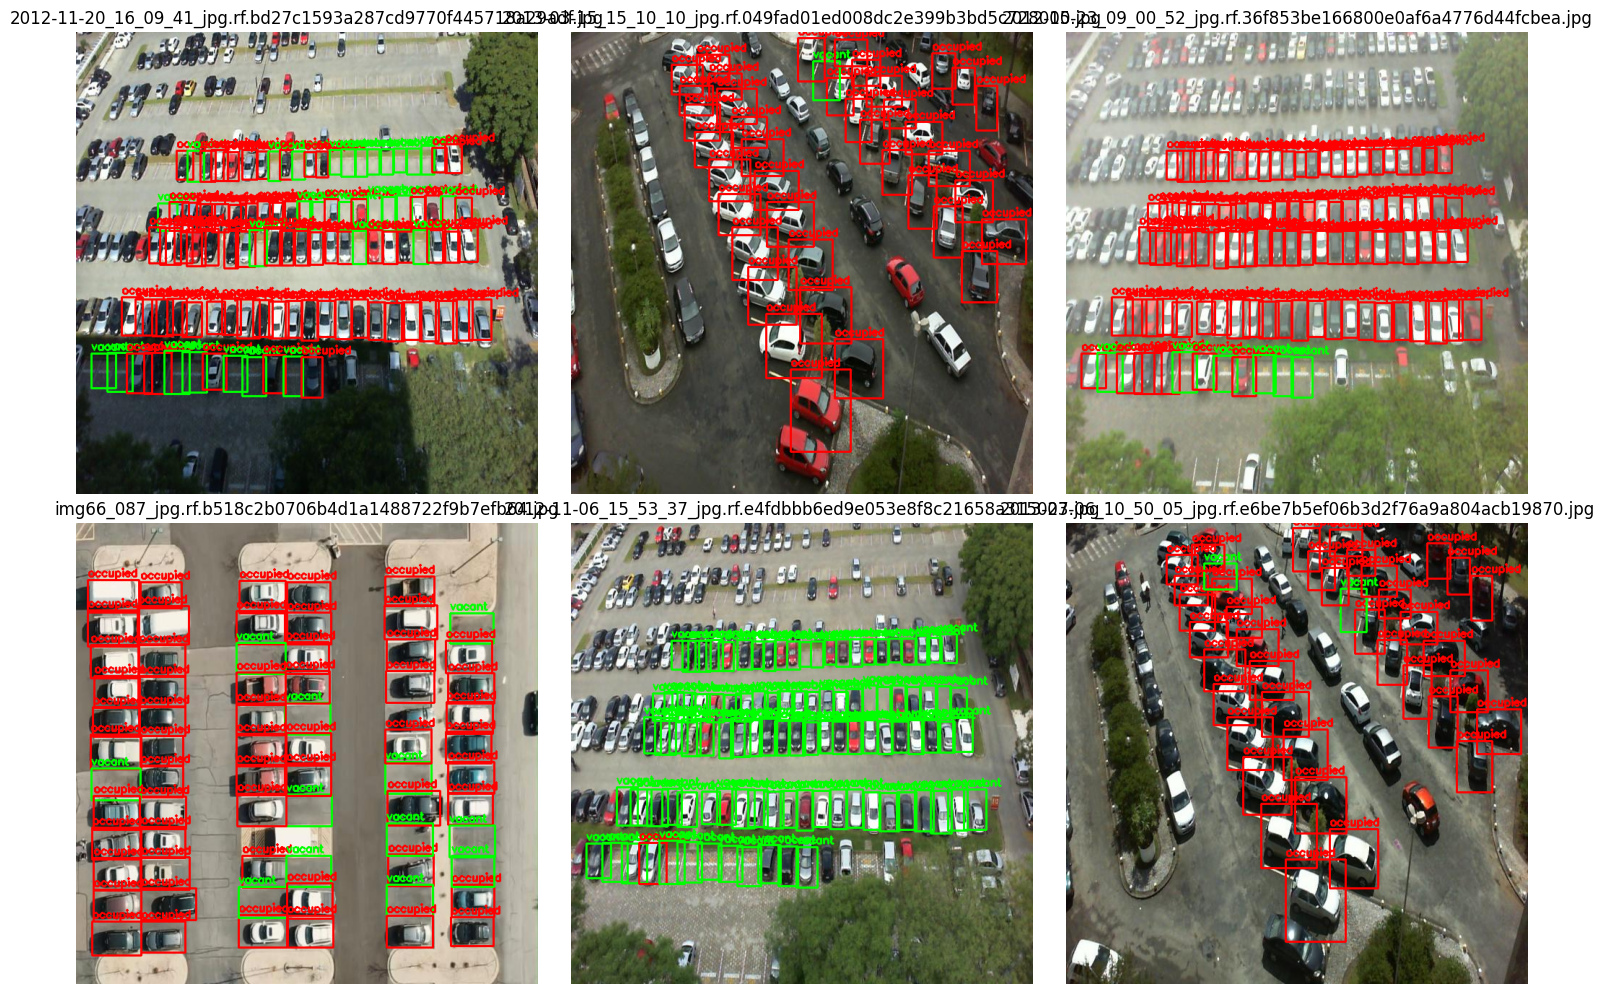

In [32]:
# Set this to your dataset path
# images_dir = "PKLot_YOLORdy/images/train"
# labels_dir = "PKLot_YOLORdy/labels/train"

images_dir = "Datasets/CompleteDataset-YOLORdy/images/train"
labels_dir = "Datasets/CompleteDataset-YOLORdy/labels/train"

class_names = ['vacant', 'occupied']

#Get a set of 6 random images
image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
sampled_images = random.sample(image_files, 6)

#draw the bounding boxes on the image
def draw_boxes(image_path, label_path):
    img = cv2.imread(image_path)
    h, w = img.shape[:2]

    with open(label_path, 'r') as f:
        for line in f:
            class_id, x_center, y_center, box_w, box_h = map(float, line.strip().split())
            x_center *= w
            y_center *= h
            box_w *= w
            box_h *= h

            x1 = int(x_center - box_w / 2)
            y1 = int(y_center - box_h / 2)
            x2 = int(x_center + box_w / 2)
            y2 = int(y_center + box_h / 2)

            class_id = int(class_id)
            color = (0, 255, 0) if class_id == 0 else (0, 0, 255)
            label = class_names[class_id]
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Plot the images with thier bound boxes
plt.figure(figsize=(15, 10))
for i, img_file in enumerate(sampled_images):
    img_path = os.path.join(images_dir, img_file)
    label_path = os.path.join(labels_dir, img_file.replace(".jpg", ".txt"))
    img_with_boxes = draw_boxes(img_path, label_path)

    plt.subplot(2, 3, i + 1)
    plt.imshow(img_with_boxes)
    plt.title(img_file)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [39]:
# Create YAML
def generate_yaml(save_path):

    dataset_dir = os.path.abspath("Datasets/CompleteDataset-YOLORdy") #get abs path

    data = {
        "path": dataset_dir,
        "train": "images/train",
        "val": "images/val",
        "test": "images/test",
        "names": {
            0: "vacant",
            1: "occupied"
        }
    }

    with open(save_path, "w") as f:
        yaml.dump(data, f, default_flow_style=False)
        print(f"YAML config saved to {save_path}")

# Usage
generate_yaml("Datasets/CompleteDataset-YOLORdy/CompleteMergedDataset.yaml")

YAML config saved to Datasets/CompleteDataset-YOLORdy/CompleteMergedDataset.yaml


In [6]:
print(os.path.exists('Datasets\CompleteDataset-YOLORdy\CompleteMergedDataset.yaml'))  # Should return True

True


## Training 

*Real training done with google colab. Very simple training for basic test sake*

Using a pretrained yolo model with 5 epochs

In [ ]:
model = YOLO('yolo11n.pt')  #Start w/ pretrained
results = model.train(data='Datasets\CompleteDataset-YOLORdy\CompleteMergedDataset.yaml', epochs=5, device=device)  #train for 5 epochs w/ customer yaml

engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=Datasets\CompleteDataset-YOLORdy\CompleteMergedDataset.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train19, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, kera

### Testing trained model

Evaluating test set of images: 100%|██████████████████████████████████████████████████████████████████████| 122/122 [00:06<00:00, 19.00it/s]


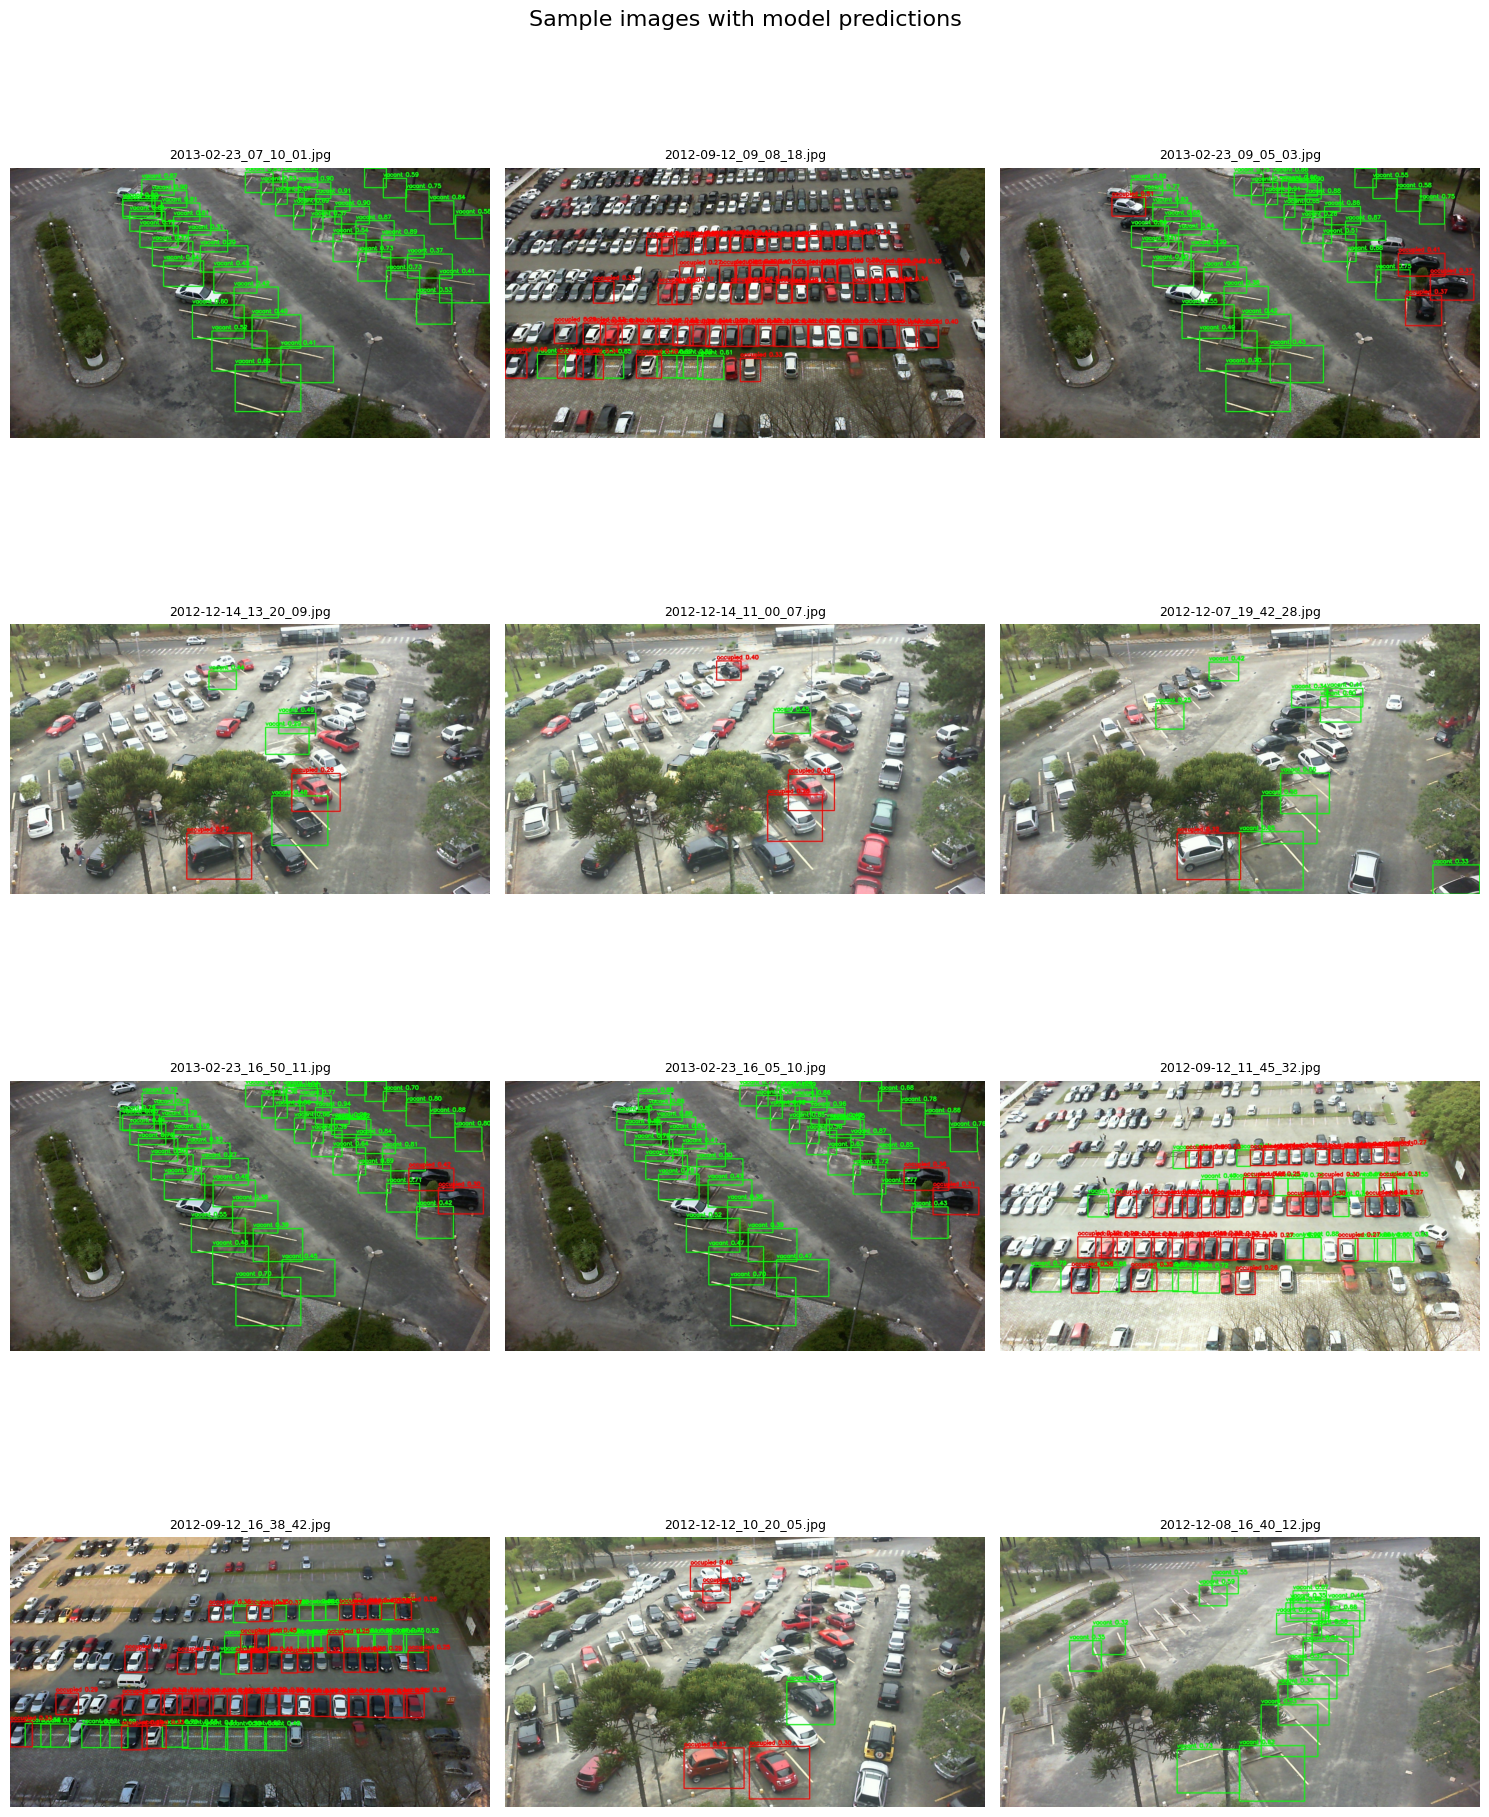


Summary Metrics Across All Images:

True Positives: 3990 out of 6200 ground truth spots
Detection Rate: 64.35%
Total False Positives (FP): 253
Total False Negatives (FN): 2210

Overall Precision: 0.940
Overall Recall: 0.644
Overall F1 Score: 0.764

Average Precision across images: 0.915
Average Recall across images:    0.587
Average F1 Score across images:  0.678

Annotated images saved to 'ModelResults/Result'
Detailed log saved to 'ModelResults/Result/inference_detailed_log.csv'


In [ ]:
# -----------------------------
# setup paths
# -----------------------------
ExternallyExportAllResultPictures = False
MaxDisplayImageOut = 12
ResultName = "Result"

model_path = 'models/preW5ep/weights/best.pt'
test_images_dir = 'PKLot_YOLORdy/images/test'
test_labels_dir = 'PKLot_YOLORdy/labels/test'

output_dir = f'ModelResults/{ResultName}'
os.makedirs(output_dir, exist_ok=True)

class_names = ['vacant', 'occupied']
iou_threshold = 0.5

# -----------------------------
# Compute the IOU
# -----------------------------
def compute_iou(box1, box2): #Computes intersection over union between two bounding boxes
    xA = max(box1[0], box2[0]) #Left
    yA = max(box1[1], box2[1]) #Top
    xB = min(box1[2], box2[2]) #Right
    yB = min(box1[3], box2[3]) #Bottom
    interArea = max(0, xB - xA) * max(0, yB - yA) #Area of intersection

    if interArea == 0:
        return 0.0 #Has No overlap

    #Area of individual boxes
    box1Area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2Area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    return interArea / float(box1Area + box2Area - interArea)

# -----------------------------
# Load the model
# -----------------------------
model = YOLO(model_path)
results_log = []

# -----------------------------
# process the test images
# -----------------------------

CurrentDisplayImageOut = 0
for filename in tqdm(os.listdir(test_images_dir), desc="Evaluating test set of images: "):
    if not filename.lower().endswith('.jpg'):
        continue #skip non jpg files

    image_path = os.path.join(test_images_dir, filename) #Path to test images
    image = cv2.imread(image_path)
    if image is None:
        continue #skip image if it cant be read

    h, w = image.shape[:2] #get image dimensions

    results = model(image_path, verbose=False)[0] #Run inference using YOLO model

    label_path = os.path.join(test_labels_dir, filename.replace('.jpg', '.txt')) #Load the ground truth YOLO labels
    gt_boxes = [] #List of ground truth boxes

    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f.readlines():
                cls_id, xc, yc, bw, bh = map(float, line.strip().split())

                #convert YOLO format (center x, y, width, height) to corner coords
                x1 = int((xc - bw / 2) * w)
                y1 = int((yc - bh / 2) * h)
                x2 = int((xc + bw / 2) * w)
                y2 = int((yc + bh / 2) * h)
                gt_boxes.append((int(cls_id), [x1, y1, x2, y2])) #append the ground truth

    #match predict to ground truth
    matched_gt = set()
    TP, FP, FN = 0, 0, 0

    for box in results.boxes: # Loop through each predicted box
        pred_cls = int(box.cls) #Predicted class
        conf = float(box.conf) # Confidence score
        xyxy = box.xyxy[0].cpu().numpy().astype(int) #bounding box coordinates
        x1, y1, x2, y2 = xyxy
        pred_box = [x1, y1, x2, y2]

        matched = False #Flag for if this pred matched ground truth

        #Try to match this prediction with a ground truth box
        for index, (gt_cls, gt_box) in enumerate(gt_boxes):
            iou = compute_iou(pred_box, gt_box)
            if iou >= iou_threshold and pred_cls == gt_cls and index not in matched_gt:
                matched_gt.add(index)
                matched = True
                break

        if matched:
            TP += 1 #True positive: matched GT
        else:
            FP += 1 #False positive: mismatch

        #Draw the predicted box on the image
        color = (0, 255, 0) if pred_cls == 0 else (0, 0, 255)
        label = class_names[pred_cls]
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, f'{label} {conf:.2f}', (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)


    FN = len(gt_boxes) - len(matched_gt) #Any ground truth box not matched = false negative

    if(ExternallyExportAllResultPictures):
        #Save annotated image to the set path
        out_path = os.path.join(output_dir, filename)
        cv2.imwrite(out_path, image)
    else:
        if(CurrentDisplayImageOut < MaxDisplayImageOut):
            out_path = os.path.join(output_dir, filename)
            cv2.imwrite(out_path, image)
            CurrentDisplayImageOut = CurrentDisplayImageOut + 1




    #Make result to log to csv
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * TP / (2 * TP + FP + FN) if (TP + FP + FN) > 0 else 0
    results_log.append({
        'filename': filename,
        'TP': TP,
        'FP': FP,
        'FN': FN,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    })

# -----------------------------
# put the results in a csv
# -----------------------------
df = pd.DataFrame(results_log)
csv_path = os.path.join(output_dir, 'inference_detailed_log.csv')
df.to_csv(csv_path, index=False)

# -----------------------------
# Output 12 sample photos
# ----------------------------

if ExternallyExportAllResultPictures == False:

    image_files = [f for f in os.listdir(output_dir) if f.lower().endswith('.jpg')]

    cols = 3
    rows = (len(image_files) + cols - 1) // cols
    plt.figure(figsize=(15, 5 * rows))

    # Plot images
    for idx, image_file in enumerate(image_files):
        img_path = os.path.join(output_dir, image_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(rows, cols, idx + 1)
        plt.imshow(img)
        plt.title(image_file, fontsize=9)
        plt.axis('off')

    plt.suptitle("Sample images with model predictions", fontsize=16)
    plt.tight_layout()
    plt.show()


# -----------------------------
# Output summary metrics
# -----------------------------

total_TP = df['TP'].sum()
total_FP = df['FP'].sum()
total_FN = df['FN'].sum()
mean_precision = df['Precision'].mean()
mean_recall = df['Recall'].mean()
mean_f1 = df['F1'].mean()



total_GT = total_TP + total_FN
overall_precision = total_TP / (total_TP + total_FP) if (total_TP + total_FP) > 0 else 0
overall_recall = total_TP / (total_TP + total_FN) if (total_TP + total_FN) > 0 else 0
overall_f1 = 2 * total_TP / (2 * total_TP + total_FP + total_FN) if (total_TP + total_FP + total_FN) > 0 else 0

#All summary metrics
print("\nSummary Metrics Across All Images:")

print(f"\nTrue Positives: {total_TP} out of {total_GT} ground truth spots")
print(f"Detection Rate: {(total_TP / total_GT * 100):.2f}%")
print(f"Total False Positives (FP): {total_FP}")
print(f"Total False Negatives (FN): {total_FN}")

#useful for real-world performance
print(f"\nOverall Precision: {overall_precision:.3f}")
print(f"Overall Recall: {overall_recall:.3f}")
print(f"Overall F1 Score: {overall_f1:.3f}")

# Useful for understanding how model performs per image
print(f"\nAverage Precision across images: {mean_precision:.3f}")
print(f"Average Recall across images:    {mean_recall:.3f}")
print(f"Average F1 Score across images:  {mean_f1:.3f}")

#Path of files produced
print(f"\nAnnotated images saved to '{output_dir}'")
print(f"Detailed log saved to '{csv_path}'")